# Прогнозирование уровня средней заработной платы в России

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


C:\Users\COMP\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


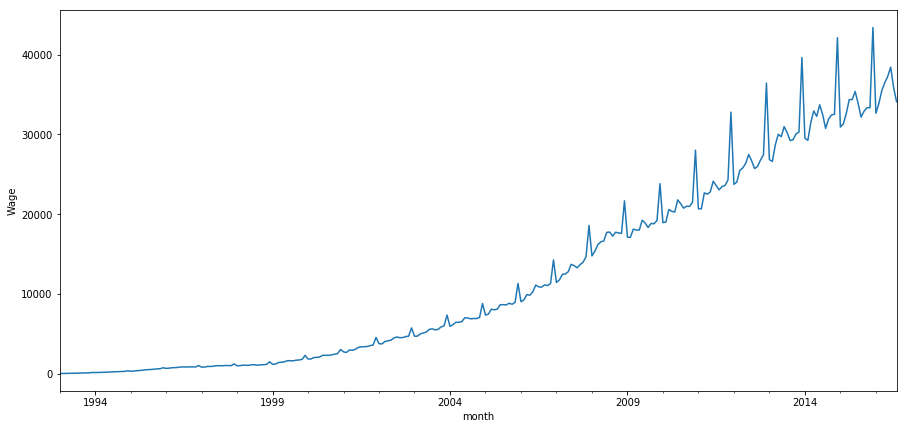

In [10]:
wage = pd.read_csv('WAG_C_M.csv', ';', index_col=['month'], parse_dates=['month'], dayfirst=True)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
plt.ylabel('Wage')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.991850


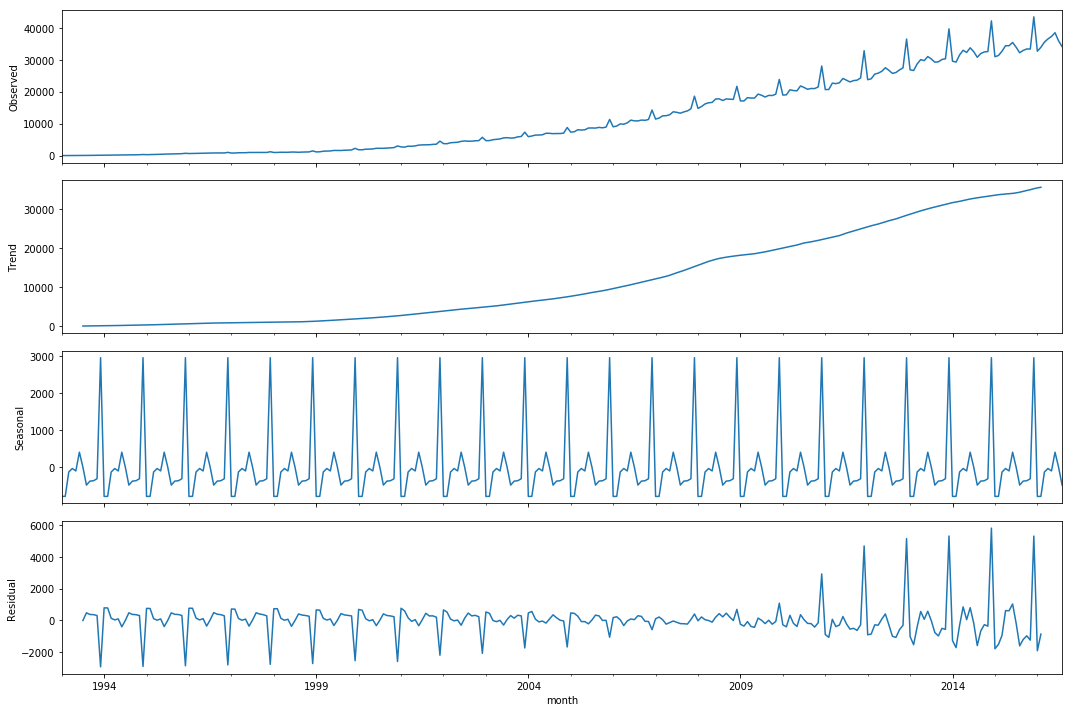

In [13]:
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.263202
Критерий Дики-Фуллера: p=0.696899


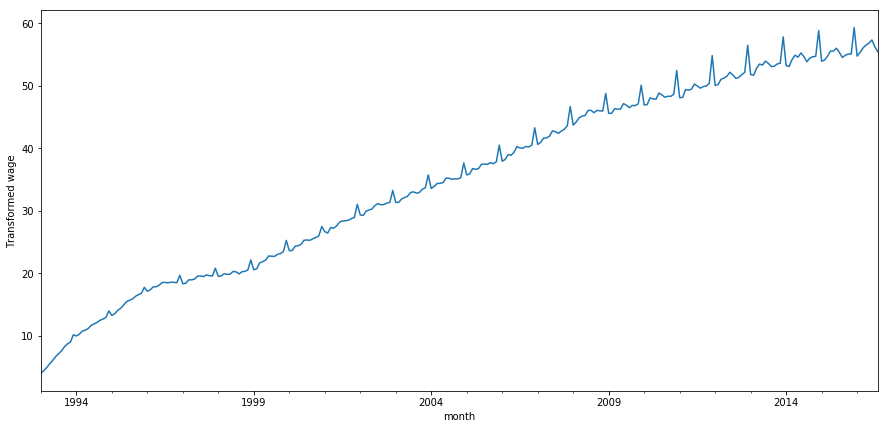

In [14]:
wage['WAG_C_M_box'], lmbda = stats.boxcox(wage.WAG_C_M)
plt.figure(figsize(15,7))
wage.WAG_C_M_box.plot()
plt.ylabel(u'Transformed wage')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M_box)[1])

### Стационарность

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.014697


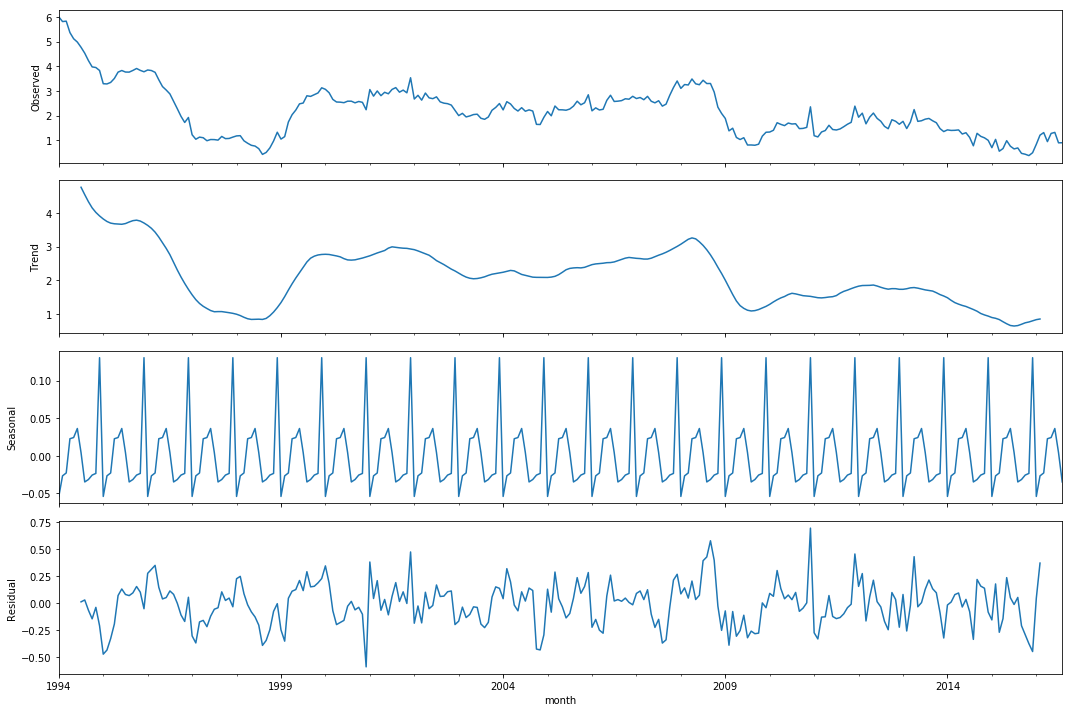

In [15]:
wage['WAG_C_M_box_diff'] = wage.WAG_C_M_box - wage.WAG_C_M_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage.WAG_C_M_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage.WAG_C_M_box_diff[12:])[1])

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но видно, что полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000000


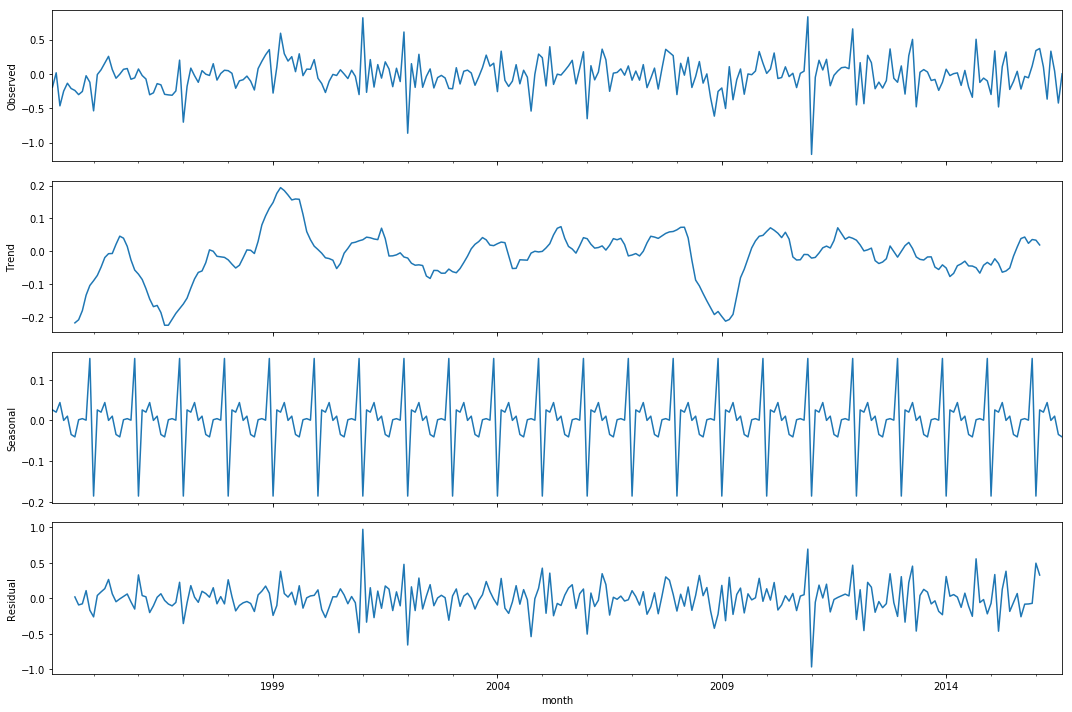

In [16]:
wage['WAG_C_M_box_diff2'] = wage['WAG_C_M_box_diff'] - wage['WAG_C_M_box_diff'].shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(wage['WAG_C_M_box_diff2'][13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(wage['WAG_C_M_box_diff2'][13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

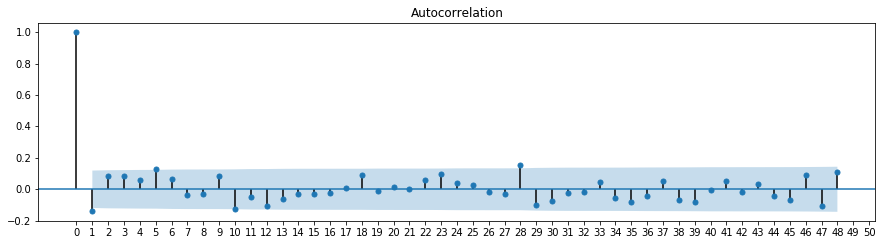

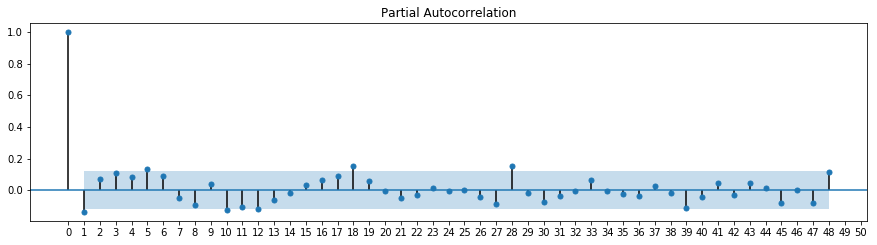

In [18]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.xticks(np.arange(0, 51, 1))
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_C_M_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
plt.xticks(np.arange(0, 51, 1))
pylab.show()

Уменьшим лаг, чтобы получше рассмотреть значения для приближения p,q

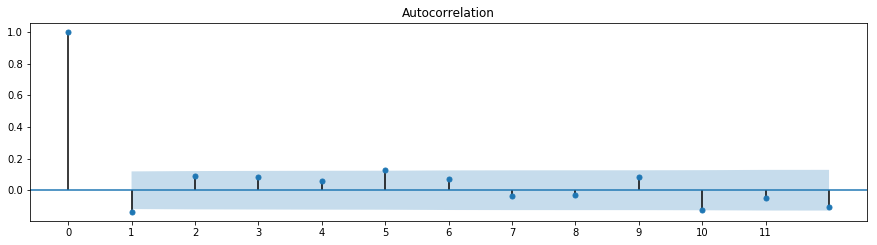

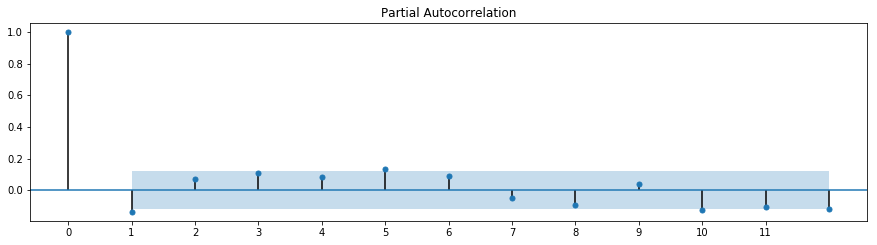

In [21]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wage.WAG_C_M_box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.xticks(np.arange(0, 12, 1))
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wage.WAG_C_M_box_diff2[13:].values.squeeze(), lags=12, ax=ax)
plt.xticks(np.arange(0, 12, 1))
pylab.show()

Начальные приближения: Q=0, q=5, P=0, p=5

In [25]:
ps = range(0, 6)
d=1
qs = range(0, 6)
Ps = [0] 
D=1
Qs = [0]

In [26]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [27]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(wage.WAG_C_M_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (1, 2, 0, 0)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 3, 0, 0)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 3, 0, 0)
wrong parameters: (3, 4, 0, 0)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 3, 0, 0)
wrong parameters: (4, 4, 0, 0)
wrong parameters: (5, 2, 0, 0)
wrong parameters: (5, 3, 0, 0)
wrong parameters: (5, 4, 0, 0)
Wall time: 38.5 s


In [28]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters        aic
21  (5, 5, 0, 0) -22.631556
15  (3, 5, 0, 0) -15.200588
9   (1, 5, 0, 0) -13.661218
18  (4, 5, 0, 0) -13.558556
12  (2, 5, 0, 0) -11.917055


Лучшая модель:

In [29]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        WAG_C_M_box   No. Observations:                  284
Model:             SARIMAX(5, 1, 5)x(0, 1, 0, 12)   Log Likelihood                  22.316
Date:                            Sun, 18 Feb 2018   AIC                            -22.632
Time:                                    19:01:48   BIC                             17.507
Sample:                                01-01-1993   HQIC                            -6.539
                                     - 08-01-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0186      3.508      0.005      0.996      -6.857       6.894
ar.L2          0.0155      2.338   

Её остатки:

Критерий Стьюдента: p=0.248964
Критерий Дики-Фуллера: p=0.000000


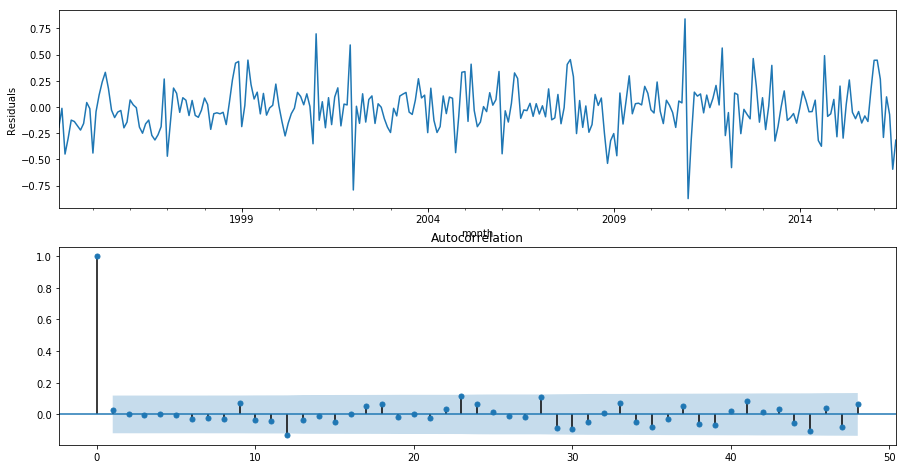

In [30]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

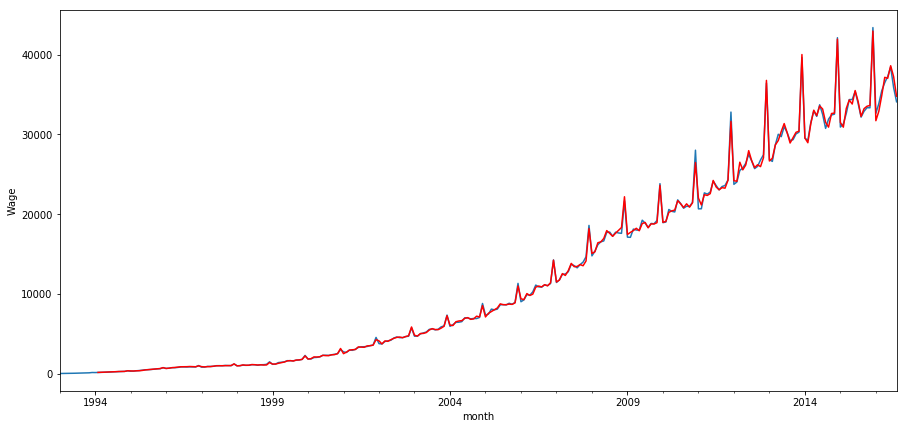

In [31]:
wage['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
wage.WAG_C_M.plot()
wage.model[13:].plot(color='r')
plt.ylabel('Wage')
pylab.show()

### Прогноз

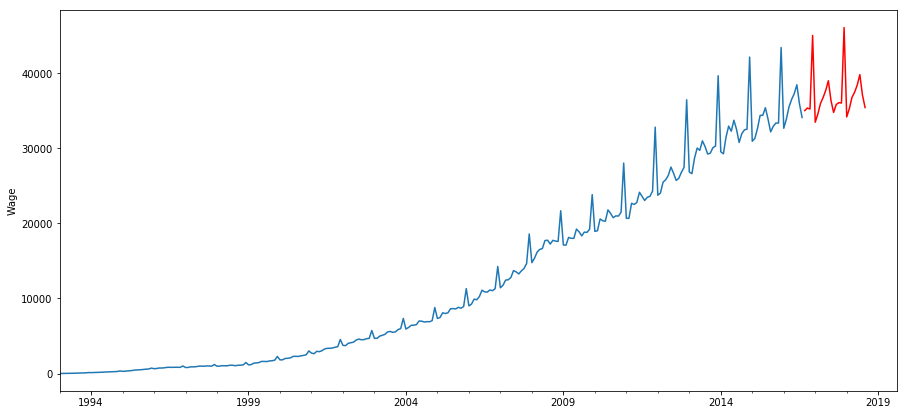

In [34]:
wage2 = wage[['WAG_C_M']]
date_list = [datetime.datetime.strptime("2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= wage2.columns)
wage2 = pd.concat([wage2, future])
wage2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15,7))
wage2.WAG_C_M.plot()
wage2.forecast.plot(color='r')
plt.ylabel('Wage')
pylab.show()